# Chapter 1. Thinking Probabilistically

In [1]:
import os
import warnings

import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import BSpline
from scipy.stats import gaussian_kde

import jax.numpy as jnp
from jax import random, vmap

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.diagnostics import hpdi, print_summary
from numpyro.infer import Predictive, SVI, Trace_ELBO, init_to_value
from numpyro.infer.autoguide import AutoLaplaceApproximation

seed=1234

if "SVG" in os.environ:
    %config InlineBackend.figure_formats = ["svg"]
warnings.formatwarning = lambda message, category, *args, **kwargs: "{}: {}\n".format(
    category.__name__, message
)
az.style.use("arviz-darkgrid")
numpyro.set_platform("cpu") # or "gpu", "tpu" depending on system

In [2]:
μ = 0.
σ = 1.
x = dist.Normal(μ, σ).sample(random.PRNGKey(0), (3,))
x

DeviceArray([ 1.8160858 , -0.48262328,  0.339889  ], dtype=float32)

In [3]:
import numpy as np

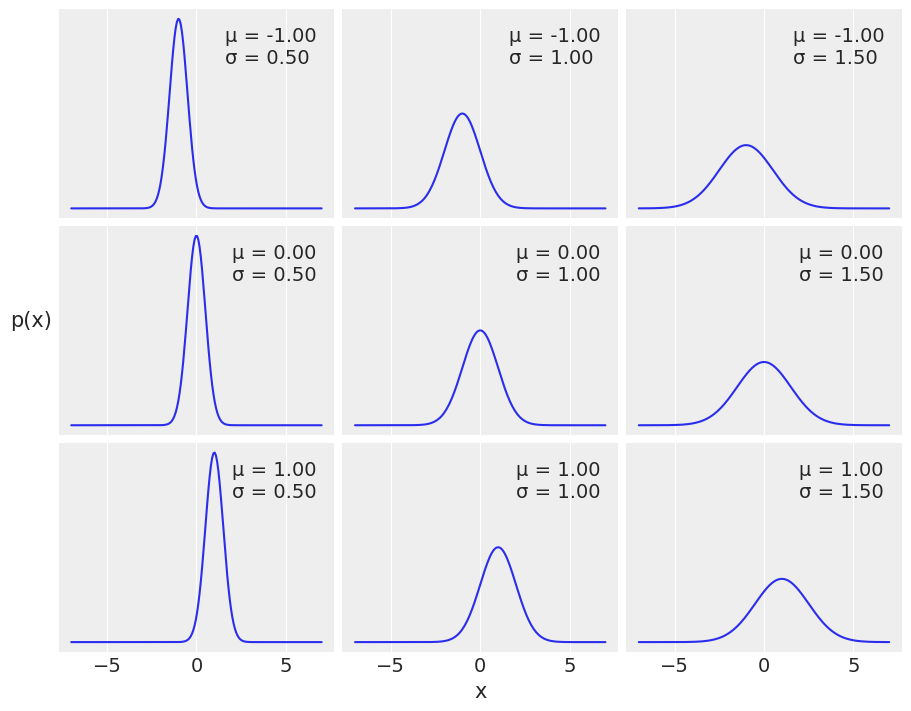

In [4]:
mu_params = [-1, 0, 1]
sd_params = [0.5, 1, 1.5]
x = jnp.linspace(-7, 7, 200)
_, ax = plt.subplots(len(mu_params), len(sd_params), sharex=True, sharey=True,
                     figsize=(9, 7), constrained_layout=True)
for i in range(3):
    for j in range(3):
        mu = mu_params[i]
        sd = sd_params[j]
        y = jnp.exp(dist.Normal(mu, sd).log_prob(x))
       
        ax[i,j].plot(x, y)
        ax[i,j].plot([], label="μ = {:3.2f}\nσ = {:3.2f}".format(mu, sd), alpha=0)
        ax[i,j].legend(loc=1)
ax[2,1].set_xlabel('x')
ax[1,0].set_ylabel('p(x)', rotation=0, labelpad=20)
ax[1,0].set_yticks([])

Text(0, 0.5, '$CO_2$ (ppmv)')

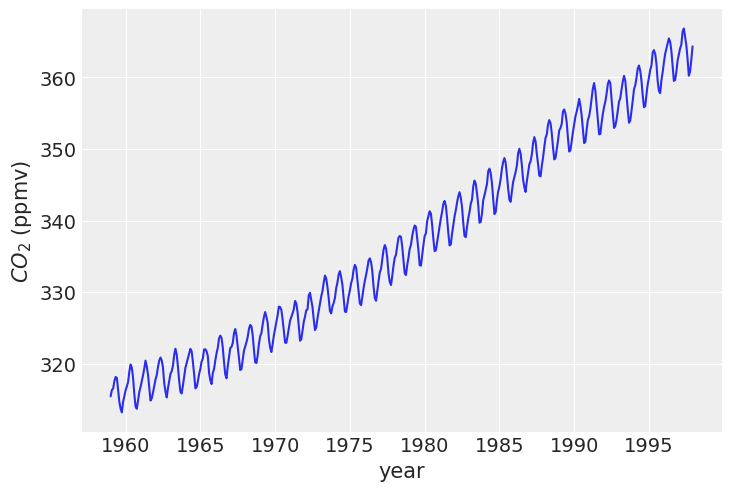

In [5]:
data = np.genfromtxt('../data/mauna_loa_CO2.csv', delimiter=',')
plt.plot(data[:,0], data[:,1])
plt.xlabel('year')
plt.ylabel('$CO_2$ (ppmv)')

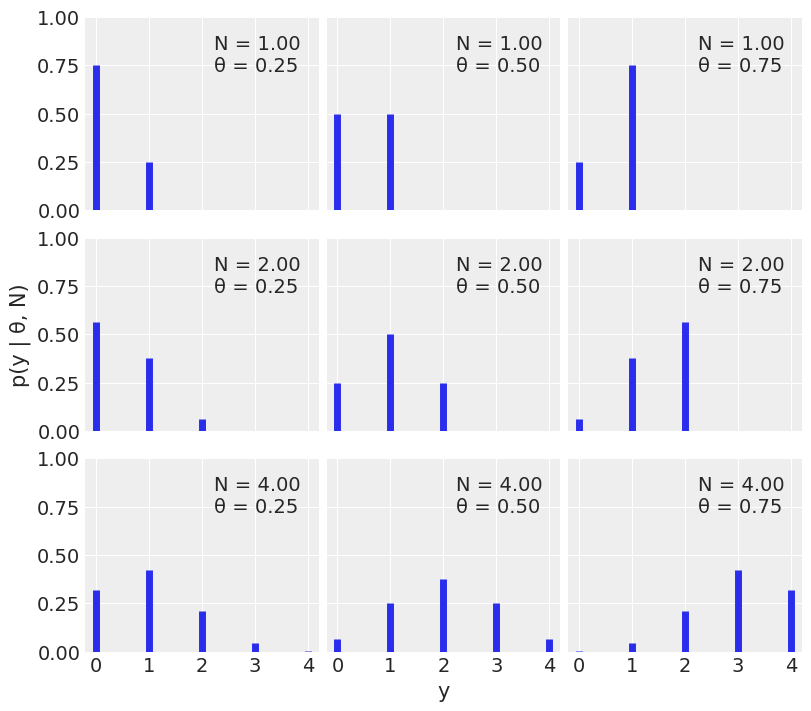

In [6]:
n_params = [1, 2, 4]  # Number of trials
p_params = [0.25, 0.5, 0.75]  # Probability of success

x = jnp.arange(0, max(n_params) + 1)
f , ax = plt.subplots(len(n_params), len(p_params), sharex=True, sharey=True,
                    figsize=(8, 7), constrained_layout=True)

for i in range(len(n_params)):
    for j in range(len(p_params)):
        n = n_params[i]
        p = p_params[j]
        y = jnp.exp(dist.Binomial(n, p).log_prob(x))

        ax[i,j].vlines(x, 0, y, colors='C0', lw=5)
        ax[i,j].set_ylim(0, 1)
        ax[i,j].plot(0, 0, label="N = {:3.2f}\nθ = {:3.2f}".format(n,p), alpha=0)
        ax[i,j].legend()

        ax[2,1].set_xlabel('y')
        ax[1,0].set_ylabel('p(y | θ, N)')
        ax[0,0].set_xticks(x)

Text(0.07, 0.5, 'p(θ)')

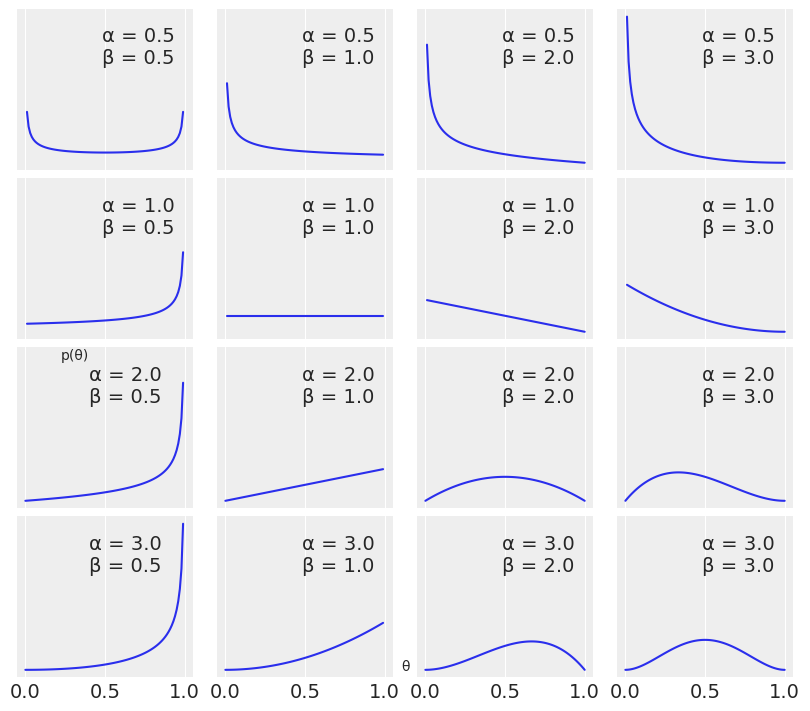

In [7]:
params = [0.5, 1, 2, 3]
x = jnp.linspace(0, 1, 100)
f, ax = plt.subplots(len(params), len(params), sharex=True, sharey=True,
                     figsize=(8, 7), constrained_layout=True)

for i in range(4):
    for j in range(4):
        a = params[i]
        b = params[j]
        y = jnp.exp(dist.Beta(a, b).log_prob(x))
        
        ax[i,j].plot(x, y)
        ax[i,j].plot(0, 0, label="α = {:2.1f}\nβ = {:2.1f}".format(a, b), alpha=0)
        ax[i,j].legend()
ax[1,0].set_yticks([])
ax[1,0].set_xticks([0, 0.5, 1])
f.text(0.5, 0.05, 'θ', ha='center')
f.text(0.07, 0.5, 'p(θ)', va='center', rotation=0)

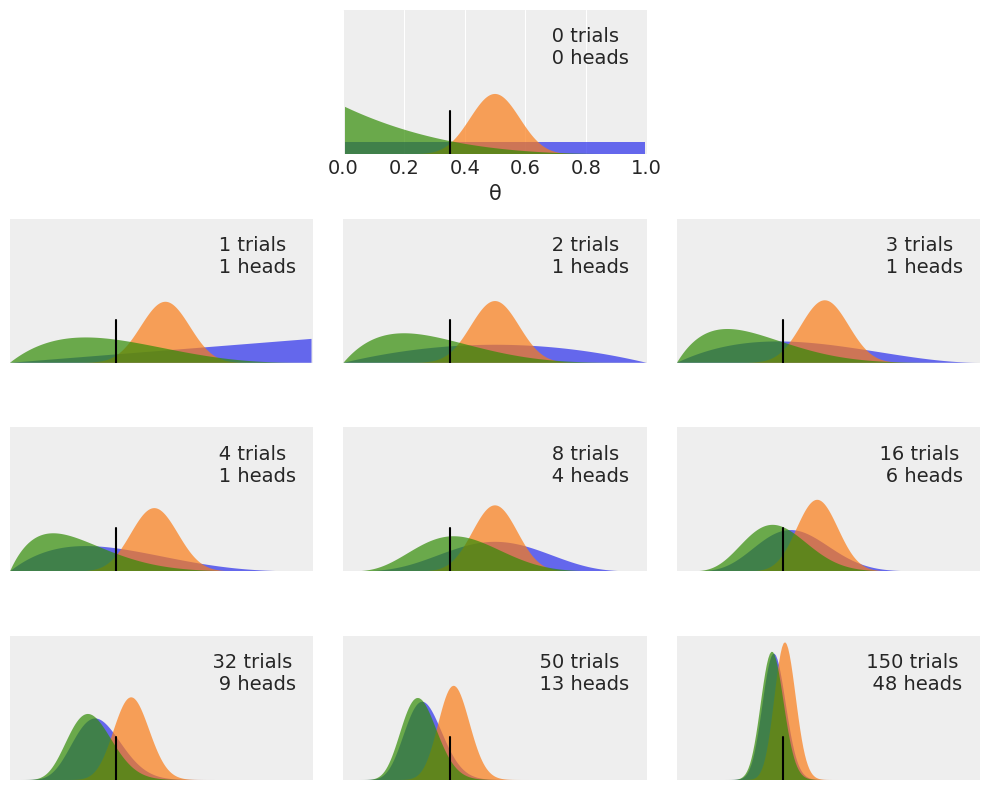

In [8]:
plt.figure(figsize=(10, 8))

n_trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta_real = 0.35

beta_params = [(1, 1), (20, 20), (1, 4)]
x = jnp.linspace(0, 1, 200)

for idx, N in enumerate(n_trials):
    if idx == 0:
        plt.subplot(4, 3, 2)
        plt.xlabel('θ')
    else:
        plt.subplot(4, 3, idx+3)
        plt.xticks([])
    y = data[idx]
    for (a_prior, b_prior) in beta_params:
        p_theta_given_y = jnp.exp(dist.Beta(a_prior + y, b_prior + N - y).log_prob(x))
        plt.fill_between(x, 0, p_theta_given_y, alpha=0.7)

    plt.axvline(theta_real, ymax=0.3, color='k')
    plt.plot(0, 0, label=f'{N:4d} trials\n{y:4d} heads', alpha=0)
    plt.xlim(0, 1)
    plt.ylim(0, 12)
    plt.legend()
    plt.yticks([])
plt.tight_layout()

 <img src="B11197_01_06.png" width="500">

<AxesSubplot:title={'center':'θ'}>

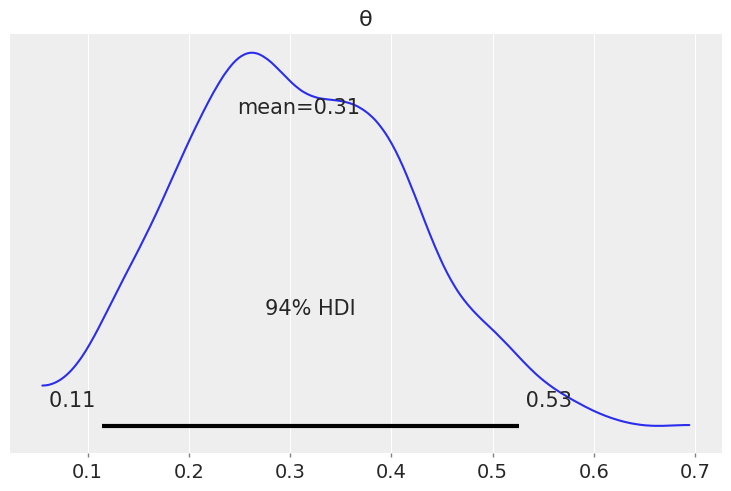

In [9]:
az.plot_posterior({'θ': dist.Beta(5, 11).sample(random.PRNGKey(seed), (1000,))})

<AxesSubplot:title={'center':'θ'}>

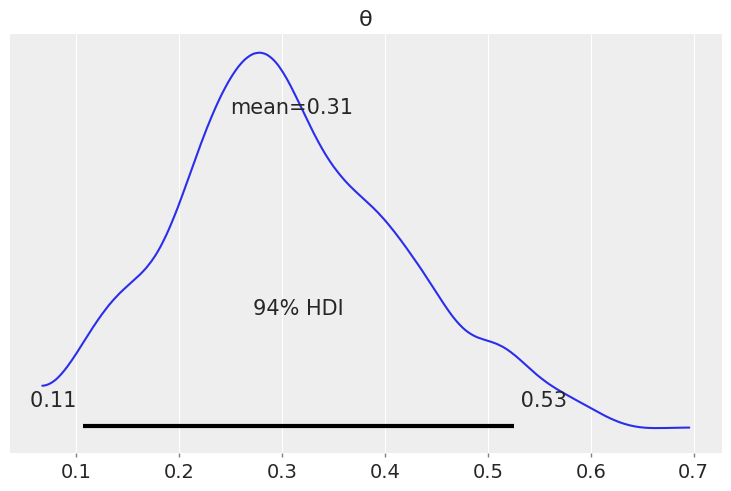

In [10]:
with numpyro.handlers.seed(rng_seed=seed):
    N = 1000  # Samples
    b = numpyro.sample("b", dist.Beta(5, 11).expand([N]))
az.plot_posterior({'θ': b})

<img src="B11197_01_08.png" width="500">